In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table
import GCRCatalogs
import os
import warnings; warnings.simplefilter('ignore')
import healpy as hp
import healsparse as hsp
import skyproj

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times"]
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
%matplotlib inline
plt.rcParams.update({'font.size':14})

In [3]:
gc = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6')

In [4]:
gc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [5]:
matched_path = '/global/cfs/projectdirs/lsst/shared/DC2-prod/Run2.2i/addons/matched/dr6'

We select objects with $i < 24.1$ to have 90% completeness or better.

In [6]:
tracts = gc.available_tracts

In [7]:
data_truth = gc2.get_quantities(['galaxy_id', 'mag_i_lsst', 'ra', 'dec', 'redshift_true'], 
                                filters=['mag_i_lsst < 24.1', 'redshift_true <= 1.2'])

In [ ]:
data_matched = []
for ii, tract in enumerate(tracts):
    if ii%10==0:
        print(ii)
    aux_data = astropy.table.Table(gc.get_quantities(['objectId', 'ra', 'dec', 'extendedness', 'mag_i_cModel'], native_filters=f'tract == {tract}',
                                                     filters=['mag_i_cModel < 24.1', 'detect_isPrimary == True']))
    aux_data2 = astropy.table.Table.read(os.path.join(matched_path, f'matched_ids_dc2_object_run2.2i_dr6_wfd_with_metacal_{tract}.fits.gz'))
    aux_data2 = aux_data2[['objectId', 'redshift_true', 'n_neigh_truth', 'n_neigh_object', 'truthId', 'dist']]
    if len(aux_data)>0:
        tab_j = astropy.table.join(aux_data, aux_data2, keys='objectId', join_type='inner')
        data_matched.append(tab_j)

In [12]:
del aux_data
del aux_data2
del tab_j

In [13]:
tab_all = astropy.table.vstack(data_matched)

In [14]:
del data_matched

In [ ]:
tab_all.write('/pscratch/sd/l/levine/table_object_matched_i_lt_241.fits.gz', overwrite=True)

In [8]:
tab_all = astropy.table.Table.read('/pscratch/sd/l/levine/table_object_matched_i_lt_241.fits.gz')

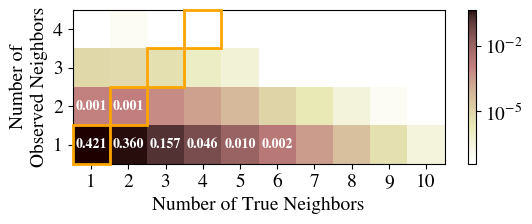

In [11]:
import matplotlib.colors
fig = plt.figure(figsize=(6,2.0))
ax = fig.add_subplot(111)
hist, xbins, ybins, im = ax.hist2d(tab_all['n_neigh_truth'] , tab_all['n_neigh_object'],
           range=[[1,10],[1,4]], bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True, norm=matplotlib.colors.LogNorm(), cmap='pink_r')
ax.set_xticks(np.arange(1, 11, 1.0))
ax.set_yticks(np.arange(1, 6, 1.0))
ax.set_xlabel('Number of True Neighbors')
ax.set_ylabel('Number of\nObserved Neighbors')
# ax.set_title('Proportion of Blends by Type')

fig.colorbar(im, ax=ax)

neigh_hist = plt.hist2d(tab_all['n_neigh_truth'], tab_all['n_neigh_object'],
           range=[[1,10],[1,4]],bins=[np.arange(0.5, 11, 1), np.arange(0.5, 5, 1)],
           density=True,norm=matplotlib.colors.LogNorm(),cmap='pink_r')


for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        if hist.T[i,j] >= 0.001:
            ax.text(xbins[j]+0.5,ybins[i]+0.5, f"{hist.T[i,j]:.3f}", 
                    color="w", ha="center", va="center", fontweight="bold", size=10)
        if i==j:
            ax.add_patch(plt.Rectangle((i+0.5, j+0.5), 1, 1, fill=False, edgecolor='orange', lw=2, zorder=10, clip_on=False))
            
plt.savefig('2dhist.png', format='png', dpi=300, bbox_inches='tight')

In [12]:
mymap = hsp.HealSparseMap.read('/global/cfs/projectdirs/lsst/shared/DC2-prod/Run2.2i/addons/supreme/dr6-wfd/supreme_dc2_dr6d_v3_i_maglim_aper_wmean.hs')

In [13]:
mymap_4096 = mymap.generate_healpix_map(4096)

In [14]:
goodpx = np.where(mymap_4096 > 24.5)

In [15]:
area_tot = np.count_nonzero(goodpx)*hp.nside2pixarea(4096, degrees=True)

In [16]:
area_tot

295.4375102845837

In [17]:
np.count_nonzero(goodpx)/len(mymap_4096)

0.0071616073449452715

In [18]:
pxnums = hp.ang2pix(4096, data_truth['ra'], data_truth['dec'], lonlat=True, nest=True)

In [19]:
pxnums_obs = hp.ang2pix(4096, tab_all['ra'], tab_all['dec'], lonlat=True, nest=True)
good_obs = np.in1d(pxnums_obs, goodpx)
print('Objects kept', np.count_nonzero(good_obs), np.count_nonzero(good_obs)/len(tab_all))
tab_all = tab_all[good_obs]

Objects kept 24543620 0.9750045157820375


In [20]:
good_truth = np.in1d(pxnums, goodpx)

In [21]:
np.count_nonzero(good_truth)/len(tab_all['ra'])

0.7595017768365058

In [22]:
ismatched = np.in1d(data_truth['galaxy_id'][good_truth], tab_all['truthId'][tab_all['extendedness']>0.5])

In [23]:
np.count_nonzero(ismatched==False)/np.count_nonzero(ismatched)

0.09387801927512457

In [28]:
import treecorr as tc

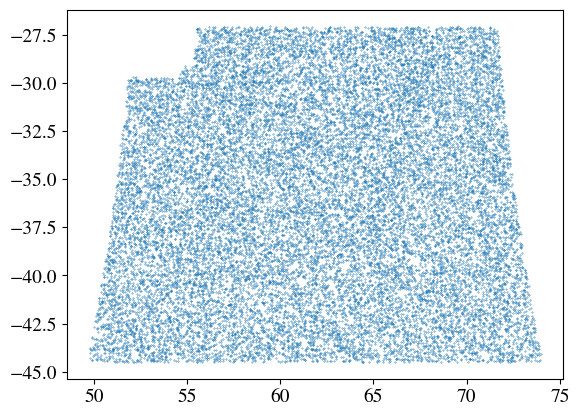

In [29]:
ra_rnd = 48 + (75-48)*np.random.random(size=10000000)
cth_min = np.sin(np.radians(-45))
cth_max = np.sin(np.radians(-26))
cth_rnd = cth_min + (cth_max - cth_min)*np.random.random(size=len(ra_rnd))
dec_rnd = np.degrees(np.arcsin(cth_rnd))
pxnums = hp.ang2pix(4096, ra_rnd, dec_rnd, lonlat=True, nest=True)
good_rnd = np.in1d(pxnums, goodpx)
ra_rnd = ra_rnd[good_rnd]
dec_rnd = dec_rnd[good_rnd]
plt.scatter(ra_rnd[::300], dec_rnd[::300], s=0.1)

In [25]:
cat_rnd = tc.Catalog(ra=ra_rnd, dec=dec_rnd, ra_units='deg', dec_units='deg', npatch=30)

In [26]:
minsep = 1
maxsep=250
rr = tc.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=12, sep_units='arcmin')

In [27]:
rr.process(cat_rnd)

In [28]:
rr.meanr

array([  1.31214253,   2.08359057,   3.30122634,   5.2306784 ,
         8.28688449,  13.12850613,  20.79595961,  32.94236459,
        52.1744493 ,  82.58527786, 130.71155802, 206.54239325])

In [24]:
galaxies = (tab_all['extendedness'] > 0.5)

In [25]:
oto = (tab_all['n_neigh_truth'] == 1) & (tab_all['n_neigh_object']==1)

In [26]:
mtm = (tab_all['n_neigh_truth'] > 1)

In [27]:
shred = (tab_all['n_neigh_truth'] < tab_all['n_neigh_object'])

In [28]:
blend = (tab_all['n_neigh_truth'] > tab_all['n_neigh_object'])

In [29]:
lost = ~np.in1d(data_truth['galaxy_id'][good_truth], tab_all['truthId'])

In [30]:
np.count_nonzero(lost)

1539987

In [28]:
def compute_corr(cat, cat_rnd):
    dd = tc.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=12, sep_units='arcmin')
    dr = tc.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=12, sep_units='arcmin')
    dd.process(cat)
    dr.process(cat, cat_rnd)
    xi, _ = dd.calculateXi(rr, dr)
    cov_jk = dd.estimate_cov('jackknife')
    return dd.meanr, xi, cov_jk
def calculate_z_distribution(catalog, zmin, zmax):
    '''Calculate histogram of redshift values
    Inputs:
    ----------
    catalog - source catalog
    zmin & zmax - redshift bin edges
    
    Returns:
    -------
    List of n(z) and list of bin centers
    '''
    # bin_mask = (catalog['redshift_true']>zmin) & (catalog['redshift_true']<zmax)
    n_z, bin_edge = np.histogram(catalog, bins=100, range=(0, 1.5))
    bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]
    return n_z, bin_centers

In [31]:
masks = {}
masks['all'] = galaxies
masks['1t1'] = (oto) & (galaxies)
masks['mtm'] = (mtm) & (galaxies)
masks['meas_other'] = (galaxies) & (~mtm) & (~oto)
masks['artifact'] = (galaxies) & (shred)
masks['true_all'] = np.ones(np.count_nonzero(good_truth), dtype=bool)
masks['true_lost'] = lost

# Maps

In [22]:
from matplotlib.gridspec import GridSpec

In [23]:
nside=4096

pxvals = hp.ang2pix(nside, data_truth['ra'], data_truth['dec'], lonlat=True)
px_unique, px_count = np.unique(pxvals,return_counts=True)
hp_true = np.zeros(hp.nside2npix(nside)) + hp.UNSEEN
hp_true[px_unique] = px_count

pxvals = hp.ang2pix(nside, tab_all['ra'], tab_all['dec'], lonlat=True)
px_unique, px_count = np.unique(pxvals,return_counts=True)
hp_obs = np.zeros(hp.nside2npix(nside)) + hp.UNSEEN
hp_obs[px_unique] = px_count

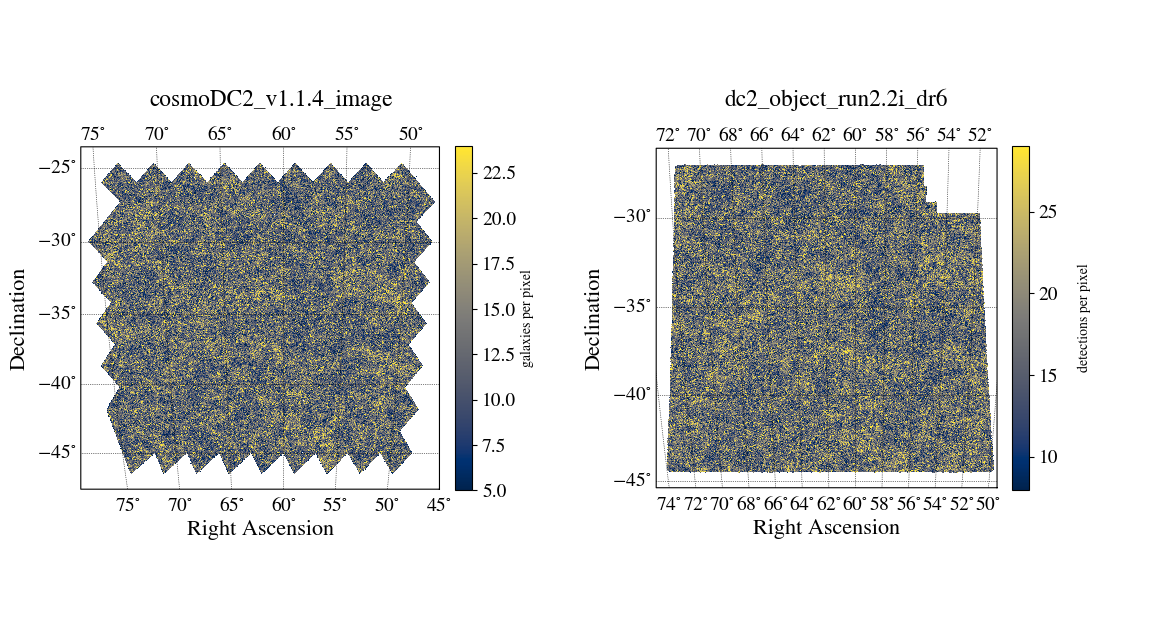

In [39]:
fig = plt.figure(1, figsize=(14, 8))
gs = GridSpec(1, 4, width_ratios=[1.05, .24, 1, .24], height_ratios=[1])
fig.clf()

ax1 = fig.add_subplot(gs[0])
sp = skyproj.McBrydeSkyproj(ax=ax1, lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])
_ = sp.draw_hpxmap(hp_true, nest=False, cmap=plt.colormaps['cividis'])

ypad=.83
xpad=-2.68

cb1 = fig.add_subplot(gs[1], frame_on=False, visible=True, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
cb1.set_title('cosmoDC2_v1.1.4_image', y=ypad, x=xpad-.1)
cb1.yaxis.set_label_coords(0.16,0.5)
cb1.set_ylabel('galaxies per pixel', size=10)
plt.colorbar(fraction=0.044, pad=0.04)

ax2 = fig.add_subplot(gs[2])
sp = skyproj.McBrydeSkyproj(ax=ax2, lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])
_ = sp.draw_hpxmap(hp_obs, nest=False, cmap=plt.colormaps['cividis'])

cb2 = fig.add_subplot(gs[3], frame_on=False, visible=True, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
cb2.set_title('dc2_object_run2.2i_dr6', y=ypad, x=xpad)
cb2.yaxis.set_label_coords(0.16,0.5)
cb2.set_ylabel('detections per pixel', size=10)
plt.colorbar(fraction=0.046, pad=0.04)


# plt.show()
plt.savefig('dc2_dr6.png', format='png', dpi=300, bbox_inches='tight')

# Skysim5000 Maps

In [21]:
gc3 = GCRCatalogs.load_catalog('skysim5000_v1.1.2')
data_skysim = gc3.get_quantities(['ra', 'dec'], 
                                filters=['mag_i_lsst < 24.1', 'redshift_true <= 1.2'])

In [56]:
import matplotlib.patches as mpatches

In [52]:
nside=2048
# nside=4096

pxvals = hp.ang2pix(nside, data_truth['ra'], data_truth['dec'], lonlat=True)
px_unique_truth, px_count = np.unique(pxvals,return_counts=True)

pxvals = hp.ang2pix(nside, tab_all['ra'], tab_all['dec'], lonlat=True)
px_unique_obs, px_count = np.unique(pxvals,return_counts=True)

pxvals = hp.ang2pix(nside, data_skysim['ra'], data_skysim['dec'], lonlat=True)
px_unique, px_count = np.unique(pxvals,return_counts=True)
hp_skysim = np.zeros(hp.nside2npix(nside)) + hp.UNSEEN
hp_skysim[px_unique] = px_count

hp_skysim_cb = hp_skysim
hp_skysim_cb[px_unique] = 1
hp_skysim_cb[px_unique_truth] = 2
hp_skysim_cb[px_unique_obs] = 3

In [97]:
np.save('skysim_cb_hpmap.npy', hp_skysim_cb)

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 6))

sp = skyproj.HammerSkyproj(ax=ax, lon_0=60, extent=[-20, 100, -89.9, 1], )
_ = sp.draw_hpxmap(hp_skysim_cb, nest=False, cmap=plt.colormaps['cividis'], zoom=False)

# Now create and show the labels:
skysim_patch = mpatches.Patch(color='#00224e', label='Skysim5000')
truth_patch = mpatches.Patch(color='#7d7c78', label='CosmoDC2')
obs_patch = mpatches.Patch(color='#ffe83d', label='DC2 Observed')
leg = plt.legend(handles=[obs_patch, truth_patch, skysim_patch], loc='lower right', fancybox=False, framealpha=.9, edgecolor='.05',)
leg.set_zorder(1e109)

# plt.show()
plt.savefig('skysim_plot.png', format='png', dpi=300, bbox_inches='tight')

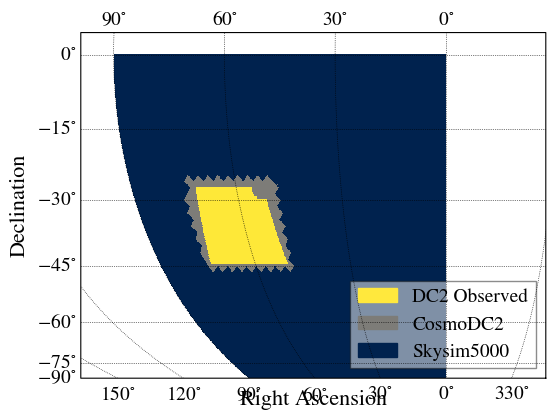

In [96]:
fig, ax = plt.subplots(1, figsize=(6, 6))

# sp = skyproj.McBrydeSkyproj(ax=ax,)# lon_0=60, lat_0=-30, extent=[40, 80, -45, -20])
# sp = skyproj.LaeaSkyproj(ax=ax, lon_0=60)
# sp = skyproj.HammerSkyproj(ax=ax, lon_0=60, extent=[0, 90, -90, 0])
sp = skyproj.EqualEarthSkyproj(ax=ax)
_ = sp.draw_hpxmap(hp_skysim_cb, nest=False, cmap=plt.colormaps['cividis'])
# ax.axes.xaxis.set_ticklabels([])
# Hide the bottom label:
# print(ax.get_children())
# ax.get_children()[6].set_text('awaaga')

# Now create and show the labels:
skysim_patch = mpatches.Patch(color='#00224e', label='Skysim5000')
truth_patch = mpatches.Patch(color='#7d7c78', label='CosmoDC2')
obs_patch = mpatches.Patch(color='#ffe83d', label='DC2 Observed')
leg = plt.legend(handles=[obs_patch, truth_patch, skysim_patch], loc='lower right', fancybox=False, framealpha=.5, edgecolor='.1', )

# plt.show()

# # plt.show()
# plt.savefig('dc2_dr6.png', format='png', dpi=300, bbox_inches='tight')

In [94]:
ax.get_children()

 Text(0.5, 1.0, 'awaaga'),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

# Summary Stats

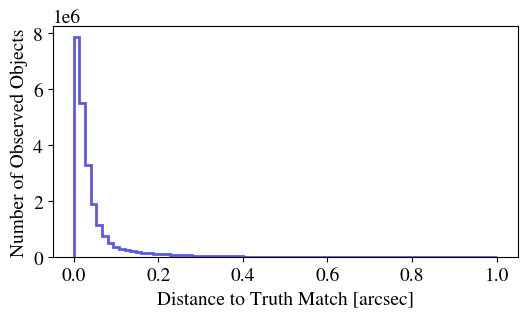

In [32]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']
plt.figure(figsize=(6,3))
plt.hist(tab_all['dist']*180/np.pi, bins=75, histtype='step', color=colorlist[0], range=(0,1), lw=2);
plt.xlabel('Distance to Truth Match [arcsec]')
plt.ylabel('Number of Observed Objects')
plt.savefig('distance.png', format='png', dpi=300, bbox_inches='tight')

In [32]:
from scipy.stats import sem
def jackknife_resample(func, data, bins):
    '''Compute jackknife resampling for a given function 
    Inputs:
    ----------
    func - input function
    data - input data catalog
    bins - number of jackknife bins
    
    Returns:
    -------
    list of means for each output of the function
    list of standard deviations for each output of the function
    '''
    jk_bins = np.random.randint(0,high=bins,size=len(data))
    
    output_list = []
    for i in range(bins):
        output_list.append(func(data[jk_bins != i]))
    
    return np.mean(output_list,axis=0), sem(output_list,axis=0)

def propagate_division_error(z, x, dx, y, dy):
    '''Helper function to propagate division error 
    '''
    return np.multiply(np.sqrt(np.add(np.square(np.divide(dx,x)),np.square(np.divide(dy,y)))),z)

In [42]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(0.2,1.2), density=True)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, tab_all['redshift_true'][masks['1t1']], 5)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, tab_all['redshift_true'][masks['mtm']], 5)
nz_all, nz_sig_all = jackknife_resample(hist_statistic, tab_all['redshift_true'][masks['all']], 5)
nz_truth, nz_sig_truth = jackknife_resample(hist_statistic, data_truth['redshift_true'][good_truth][masks['true_all']], 5)
nz_lost, nz_sig_lost = jackknife_resample(hist_statistic, data_truth['redshift_true'][good_truth][masks['true_lost']], 5)

_, bin_edge = np.histogram(tab_all['redshift_true'][masks['1t1']], bins=100, range=(0.2, 1.2), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

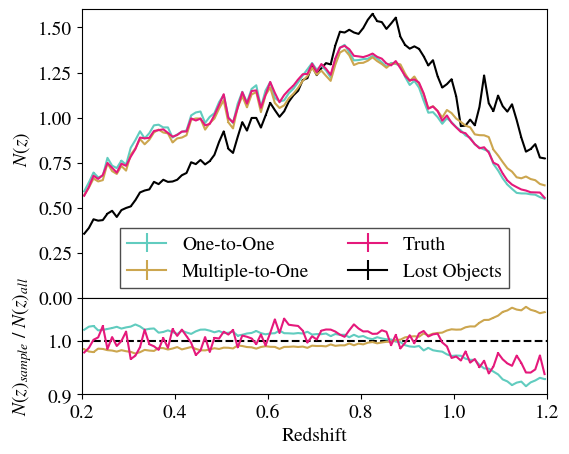

In [44]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,5))
plt.subplots_adjust(hspace=0.,wspace=0.)
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto, color=colorlist[1])
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm, color=colorlist[2])
axs[0].errorbar(nz_bin_centers, nz_truth, nz_sig_truth, color=colorlist[3])
# axs[0].errorbar(nz_bin_centers, nz_all, nz_sig_all, color=colorlist[0])
axs[0].errorbar(nz_bin_centers, nz_lost, nz_sig_lost, color='black', zorder=0)

axs[0].set_ylabel('  $N(z)$')

axs[1].axhline(1,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_all),
                propagate_division_error(np.divide(nz_oto,nz_all),nz_oto,nz_sig_oto,nz_all,nz_sig_all), color=colorlist[1])
axs[1].errorbar(nz_bin_centers,np.divide(nz_otm,nz_all),
                propagate_division_error(np.divide(nz_otm,nz_all),nz_otm,nz_sig_otm,nz_all,nz_sig_all), color=colorlist[2])
axs[1].errorbar(nz_bin_centers,np.divide(nz_truth,nz_all),
                propagate_division_error(np.divide(nz_truth,nz_all),nz_truth,nz_sig_truth,nz_all,nz_sig_all), color=colorlist[3])
# axs[1].errorbar(nz_bin_centers,np.divide(nz_lost,nz_all),
#                 propagate_division_error(np.divide(nz_lost,nz_all),nz_lost,nz_sig_lost,nz_all,nz_sig_all), color='black', zorder=0)
axs[1].set_xlabel('Redshift')
axs[1].set_ylim([.9,1.08])
axs[1].set_ylabel('$N(z)_{sample}$ $/$ $N(z)_{all}$', labelpad=10)

axs[0].legend(['One-to-One', 'Multiple-to-One', 'Truth', 'Lost Objects'], 
              loc='lower center', ncol=2, fancybox=False, framealpha=1, edgecolor='.3')

axs[0].set_xlim(0.2,1.2)
axs[1].set_xlim(0.2,1.2)
axs[0].set_ylim(0, 1.6)

axs[0].get_xaxis().set_visible(False)
plt.savefig('Nz_plot.png', format='png', dpi=300, bbox_inches='tight')

In [42]:
test_statistic = lambda x: (np.mean(x), np.median(x), np.std(x))
def print_statistics(catalog, zmin, zmax):
    '''Helper function to print mean, median, and st.dev for a given catalog
    Inputs:
    ----------
    catalog - input catalog (DataFrame)
    zmin, zmax - redshift bin edges
    
    Returns:
    -------
    None
    '''
    bin_mask = (catalog>zmin) & (catalog<zmax)
    a,b = jackknife_resample(test_statistic, catalog[bin_mask], 10)
    return a,b
    # print("Mean:", np.round(a[0],5), '±', np.round(b[0],5))
    # print("Median:", np.round(a[1],5), '±', np.round(b[1],5))
    # print("Std. Dev.:", np.round(a[2],5), '±', np.round(b[2],5))
    
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)

print('Redshift & One-to-One & Multiple-to-One & All Observed\\\\')
print('\hline')

idx=0 #mean

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    stats_1t1 = print_statistics(tab_all['redshift_true'][masks['1t1']], zmin, zmax)
    stats_mtm = print_statistics(tab_all['redshift_true'][masks['mtm']], zmin, zmax)
    stats_all = print_statistics(tab_all['redshift_true'][masks['all']], zmin, zmax)
    
    
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${stats_1t1[0][idx]:.6f} \pm {stats_1t1[1][idx]:.6f}$ & \
${stats_mtm[0][idx]:.6f} \pm {stats_mtm[1][idx]:.6f}$ & \
${stats_all[0][idx]:.6f} \pm {stats_all[1][idx]:.6f}$\\\\''')
print('\hline')  
zmin = 0.2; zmax = 1.2 
n_bins = 10
binlist = np.linspace(zmin,zmax,n_bins+1)
for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    stats_1t1 = print_statistics(tab_all['redshift_true'][masks['1t1']], zmin, zmax)
    stats_mtm = print_statistics(tab_all['redshift_true'][masks['mtm']], zmin, zmax)
    stats_all = print_statistics(tab_all['redshift_true'][masks['all']], zmin, zmax)
    
    
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${stats_1t1[0][idx]:.6f} \pm {stats_1t1[1][idx]:.6f}$ & \
${stats_mtm[0][idx]:.6f} \pm {stats_mtm[1][idx]:.6f}$ & \
${stats_all[0][idx]:.6f} \pm {stats_all[1][idx]:.6f}$\\\\''')

idx=1 #median
zmin = 0.2; zmax = 1.2 
n_bins = 5
binlist = np.linspace(zmin,zmax,n_bins+1)

print('Redshift & One-to-One & Multiple-to-One & All Observed\\\\')
print('\hline')

for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    stats_1t1 = print_statistics(tab_all['redshift_true'][masks['1t1']], zmin, zmax)
    stats_mtm = print_statistics(tab_all['redshift_true'][masks['mtm']], zmin, zmax)
    stats_all = print_statistics(tab_all['redshift_true'][masks['all']], zmin, zmax)
    
    
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${stats_1t1[0][idx]:.6f} \pm {stats_1t1[1][idx]:.6f}$ & \
${stats_mtm[0][idx]:.6f} \pm {stats_mtm[1][idx]:.6f}$ & \
${stats_all[0][idx]:.6f} \pm {stats_all[1][idx]:.6f}$\\\\''')
print('\hline')
zmin = 0.2; zmax = 1.2 
n_bins = 10
binlist = np.linspace(zmin,zmax,n_bins+1)
for i in range(n_bins):
    zmin = binlist[i]; zmax = binlist[i+1]
    stats_1t1 = print_statistics(tab_all['redshift_true'][masks['1t1']], zmin, zmax)
    stats_mtm = print_statistics(tab_all['redshift_true'][masks['mtm']], zmin, zmax)
    stats_all = print_statistics(tab_all['redshift_true'][masks['all']], zmin, zmax)
    
    
    print(f'''{zmin:.1f}-{zmax:.1f} & 
${stats_1t1[0][idx]:.6f} \pm {stats_1t1[1][idx]:.6f}$ & \
${stats_mtm[0][idx]:.6f} \pm {stats_mtm[1][idx]:.6f}$ & \
${stats_all[0][idx]:.6f} \pm {stats_all[1][idx]:.6f}$\\\\''')

#Full samples:
oto_full_samp = print_statistics(tab_all['redshift_true'][masks['1t1']], 0.2, 1.2)
mtm_full_samp = print_statistics(tab_all['redshift_true'][masks['mtm']], 0.2, 1.2)
all_full_samp = print_statistics(tab_all['redshift_true'][masks['all']], 0.2, 1.2)
    
idx=0
print(f'''${oto_full_samp[0][idx]:.6f} \pm {oto_full_samp[1][idx]:.6f}$ & \
${mtm_full_samp[0][idx]:.6f} \pm {mtm_full_samp[1][idx]:.6f}$ & \
${all_full_samp[0][idx]:.6f} \pm {all_full_samp[1][idx]:.6f}$\\\\''')
idx=1
print(f'''${oto_full_samp[0][idx]:.6f} \pm {oto_full_samp[1][idx]:.6f}$ & \
${mtm_full_samp[0][idx]:.6f} \pm {mtm_full_samp[1][idx]:.6f}$ & \
${all_full_samp[0][idx]:.6f} \pm {all_full_samp[1][idx]:.6f}$\\\\''')

Redshift & One-to-One & Multiple-to-One & All Observed\\
\hline
0.2-0.4 & 
$0.307820 \pm 0.000005$ & $0.307970 \pm 0.000005$ & $0.307923 \pm 0.000003$\\
0.4-0.6 & 
$0.503548 \pm 0.000007$ & $0.503683 \pm 0.000003$ & $0.503611 \pm 0.000001$\\
0.6-0.8 & 
$0.703720 \pm 0.000003$ & $0.703945 \pm 0.000004$ & $0.703836 \pm 0.000003$\\
0.8-1.0 & 
$0.893680 \pm 0.000004$ & $0.894746 \pm 0.000003$ & $0.894292 \pm 0.000002$\\
1.0-1.2 & 
$1.089096 \pm 0.000007$ & $1.090900 \pm 0.000007$ & $1.090175 \pm 0.000003$\\
\hline
0.2-0.3 & 
$0.251862 \pm 0.000004$ & $0.251832 \pm 0.000005$ & $0.251847 \pm 0.000003$\\
0.3-0.4 & 
$0.350766 \pm 0.000004$ & $0.350960 \pm 0.000004$ & $0.350881 \pm 0.000003$\\
0.4-0.5 & 
$0.451331 \pm 0.000004$ & $0.451273 \pm 0.000002$ & $0.451297 \pm 0.000003$\\
0.5-0.6 & 
$0.550850 \pm 0.000004$ & $0.550859 \pm 0.000004$ & $0.550849 \pm 0.000003$\\
0.6-0.7 & 
$0.651325 \pm 0.000004$ & $0.651351 \pm 0.000002$ & $0.651337 \pm 0.000003$\\
0.7-0.8 & 
$0.750692 \pm 0.000004$ & $0

In [37]:
hist_statistic = lambda x: np.histogram(x, bins=100, range=(12,24), density=True)[0]
nz_oto, nz_sig_oto = jackknife_resample(hist_statistic, tab_all['mag_i_cModel'][masks['1t1']], 5)
nz_otm, nz_sig_otm = jackknife_resample(hist_statistic, tab_all['mag_i_cModel'][masks['mtm']], 5)
nz_all, nz_sig_all = jackknife_resample(hist_statistic, tab_all['mag_i_cModel'][masks['all']], 5)
nz_truth, nz_sig_truth = jackknife_resample(hist_statistic, data_truth['mag_i_lsst'][good_truth][masks['true_all']], 5)
nz_lost, nz_sig_lost = jackknife_resample(hist_statistic, data_truth['mag_i_lsst'][good_truth][masks['true_lost']], 5)

_, bin_edge = np.histogram(tab_all['mag_i_cModel'][masks['1t1']], bins=100, range=(12, 24), density=True)
nz_bin_centers = 0.5 * bin_edge[1:] + 0.5 * bin_edge[:-1]

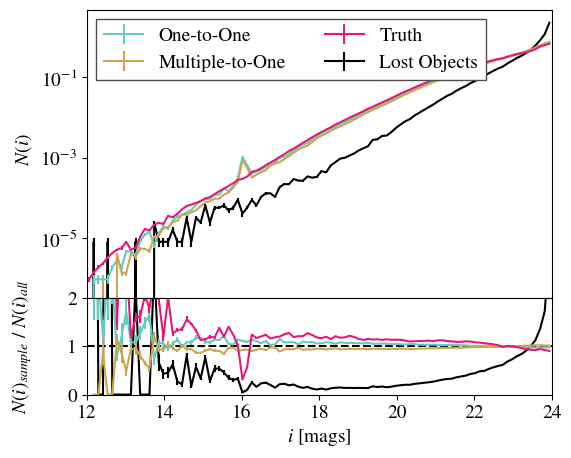

In [41]:
colorlist = ['#5e59e5', '#61ccbf', '#cca64f', '#e5197b']

fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,5))
plt.subplots_adjust(hspace=0.,wspace=0.)
axs[0].errorbar(nz_bin_centers, nz_oto, nz_sig_oto, color=colorlist[1])
axs[0].errorbar(nz_bin_centers, nz_otm, nz_sig_otm, color=colorlist[2])
axs[0].errorbar(nz_bin_centers, nz_truth, nz_sig_truth, color=colorlist[3])
# axs[0].errorbar(nz_bin_centers, nz_all, nz_sig_all, color=colorlist[0])
axs[0].errorbar(nz_bin_centers, nz_lost, nz_sig_lost, color='black', zorder=0)

axs[0].set_ylabel('  $N(i)$')

axs[1].axhline(1,c='black',ls='--')
axs[1].errorbar(nz_bin_centers,np.divide(nz_oto,nz_all),
                propagate_division_error(np.divide(nz_oto,nz_all),nz_oto,nz_sig_oto,nz_all,nz_sig_all), color=colorlist[1])
axs[1].errorbar(nz_bin_centers,np.divide(nz_otm,nz_all),
                propagate_division_error(np.divide(nz_otm,nz_all),nz_otm,nz_sig_otm,nz_all,nz_sig_all), color=colorlist[2])
axs[1].errorbar(nz_bin_centers,np.divide(nz_truth,nz_all),
                propagate_division_error(np.divide(nz_truth,nz_all),nz_truth,nz_sig_truth,nz_all,nz_sig_all), color=colorlist[3])
axs[1].errorbar(nz_bin_centers,np.divide(nz_lost,nz_all),
                propagate_division_error(np.divide(nz_lost,nz_all),nz_lost,nz_sig_lost,nz_all,nz_sig_all), color='black', zorder=0)
axs[1].set_xlabel('$i$ [mags]')
# axs[1].set_ylim([12, 1])
axs[1].set_ylabel('$N(i)_{sample}$ $/$ $N(i)_{all}$', labelpad=24)

axs[0].legend(['One-to-One', 'Multiple-to-One', 'Truth', 'Lost Objects'], 
              loc='upper left', ncol=2, fancybox=False, framealpha=1, edgecolor='.3')
axs[0].set_yscale('log')
axs[0].set_xlim(12,24)
axs[1].set_xlim(12,24)
axs[1].set_ylim(0, 2)

axs[0].get_xaxis().set_visible(False)
plt.savefig('mag_plot.png', format='png', dpi=300, bbox_inches='tight')

# 5 bins

In [52]:
zedges = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]

In [53]:
nz_out = {}
nz_out['all'] = {}
nz_out['1t1'] = {}
nz_out['mtm'] = {}
nz_out['meas_other'] = {}
nz_out['artifact'] = {}
nz_out['true_lost'] = {}
nz_out['true_all'] = {}
dndz_out = {}
dndz_out['all'] = {}
dndz_out['1t1'] = {}
dndz_out['mtm'] = {}
dndz_out['meas_other'] = {}
dndz_out['artifact'] = {}
dndz_out['true_lost'] = {}
dndz_out['true_all'] = {}

theta_out = {}
theta_out['all'] = {}
theta_out['1t1'] = {}
theta_out['mtm'] = {}
theta_out['meas_other'] = {}
theta_out['artifact'] = {}
theta_out['true_lost'] = {}
theta_out['true_all'] = {}
w_out = {}
w_out['all'] = {}
w_out['1t1'] = {}
w_out['mtm'] = {}
w_out['meas_other'] = {}
w_out['artifact'] = {}
w_out['true_lost'] = {}
w_out['true_all'] = {}
cov_out = {}
cov_out['all'] = {}
cov_out['1t1'] = {}
cov_out['mtm'] = {}
cov_out['meas_other'] = {}
cov_out['true_lost'] = {}
cov_out['true_all'] = {}
cov_out['artifact'] = {}

In [54]:
fraction_lost = []
num_old = 1
# rr_out = dict()
for i in range(len(zedges)-1):
    print(i)
    for key in masks.keys():
        print(key)
        if 'true' not in key:
            zmask = (tab_all['redshift_true'] > zedges[i]) & (tab_all['redshift_true'] < zedges[i+1])
            zmask = (zmask) & (masks[key])
            cat_here = tc.Catalog(ra=tab_all['ra'][zmask], dec=tab_all['dec'][zmask], 
                                 patch_centers=cat_rnd.patch_centers, ra_units='deg', dec_units='deg')
            
            # rr_here = tc.NNCorrelation(min_sep=1, max_sep=180, nbins=15, sep_units='arcmin')
            nz, zbins = calculate_z_distribution(tab_all['redshift_true'][zmask], zedges[i], zedges[i+1])
        else:
            zmask = (data_truth['redshift_true'][good_truth] > zedges[i]) & (data_truth['redshift_true'][good_truth] < zedges[i+1])
            zmask = (zmask) & (masks[key])
            # num_here = np.count_nonzero(zmask)
            # print(key, 'Fraction of lost objects', num_here, key)
            cat_here = tc.Catalog(ra=data_truth['ra'][good_truth][zmask], dec=data_truth['dec'][good_truth][zmask],
                                 patch_centers=cat_rnd.patch_centers, ra_units='deg', dec_units='deg')
            nz, zbins = calculate_z_distribution(data_truth['redshift_true'][good_truth][zmask], zedges[i], zedges[i+1])
            # num_old = num_here
        # if key=='true_all':
        #     sel_here = np.random.choice(np.arange(len(ra_rnd)), size=num_here, replace=False)
        #     # rr_here = tc.NNCorrelation(min_sep=1, max_sep=180, nbins=15, sep_units='arcmin')
        #     cat_rnd_here = tc.Catalog(ra=ra_rnd[sel_here], dec=dec_rnd[sel_here], ra_units='deg', dec_units='deg')
        #     rr_here.process(cat_rnd_here)
        #     # rr_out[i] = rr_here.npairs
        theta, w, cov = compute_corr(cat_here, cat_rnd)
        theta_out[key][i] = theta
        w_out[key][i] = w
        cov_out[key][i] = cov
        nz_out[key][i] = nz
        dndz_out[key][i] = zbins
        
        np.save(f'cov_DC2_DR6/cov_DC2_DR6_07_05_2023_5bin_{key}_{i}', cov)

0
all
1t1
mtm
meas_other
artifact
true_all
true_lost
1
all
1t1
mtm
meas_other
artifact
true_all
true_lost
2
all
1t1
mtm
meas_other
artifact
true_all
true_lost
3
all
1t1
mtm
meas_other
artifact
true_all
true_lost
4
all
1t1
mtm
meas_other
artifact
true_all
true_lost


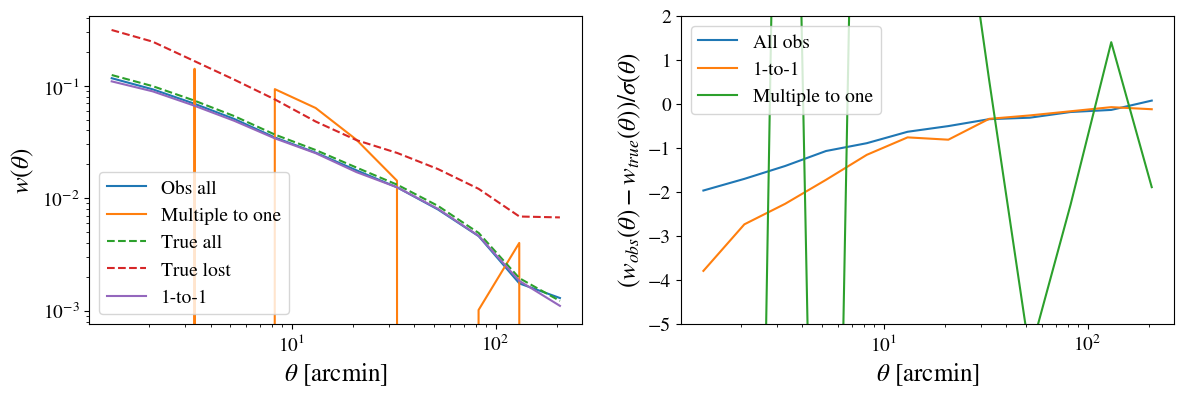

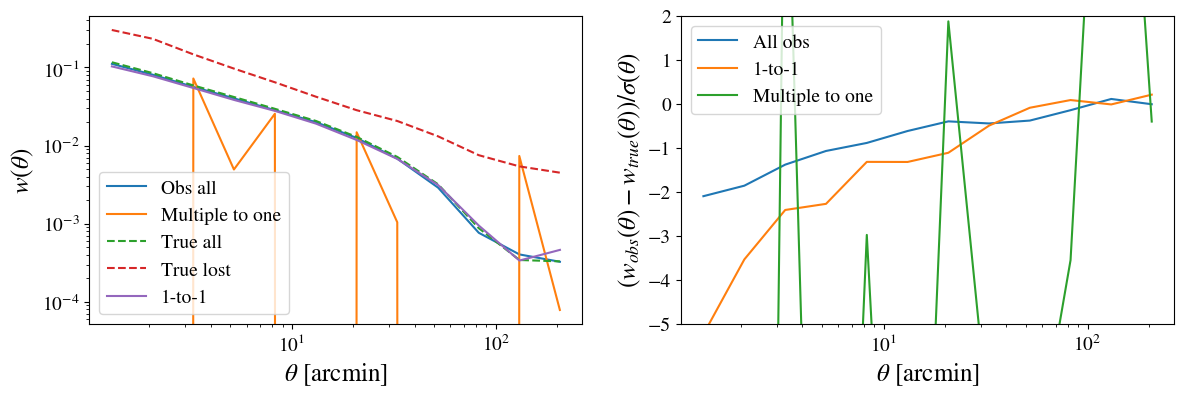

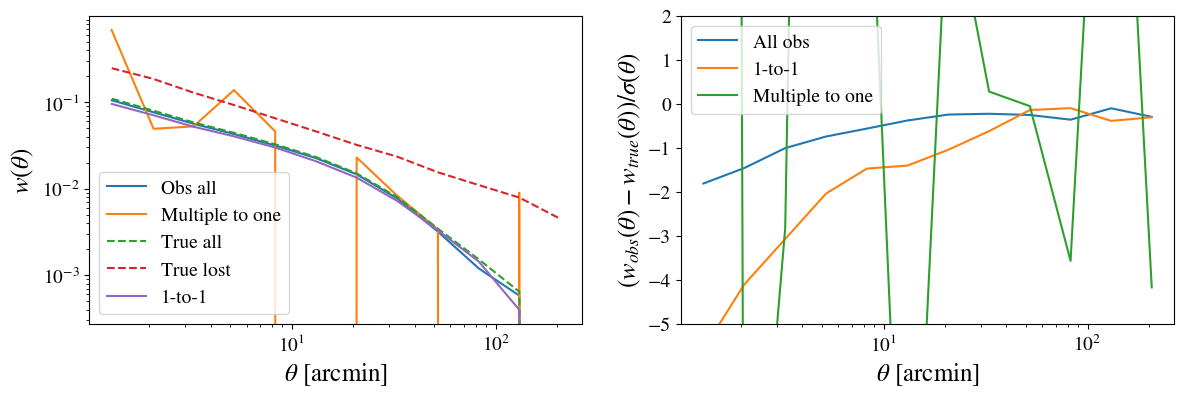

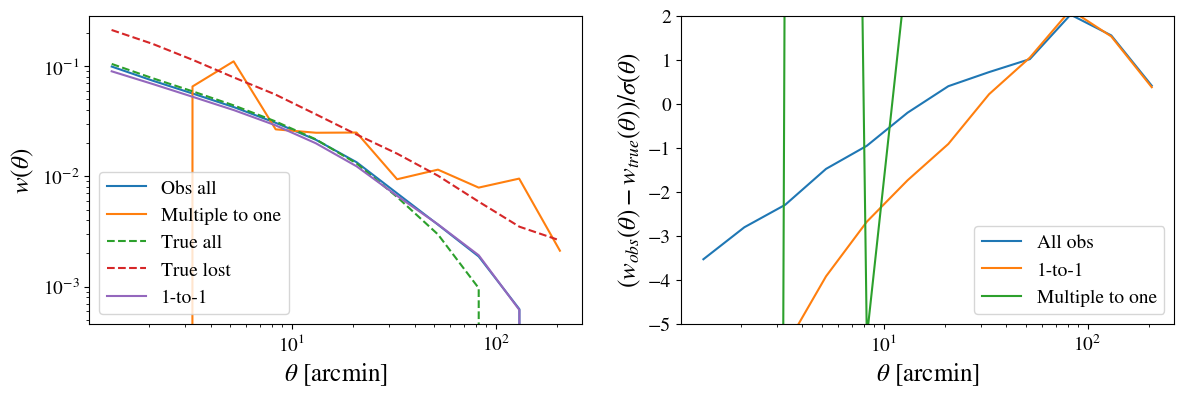

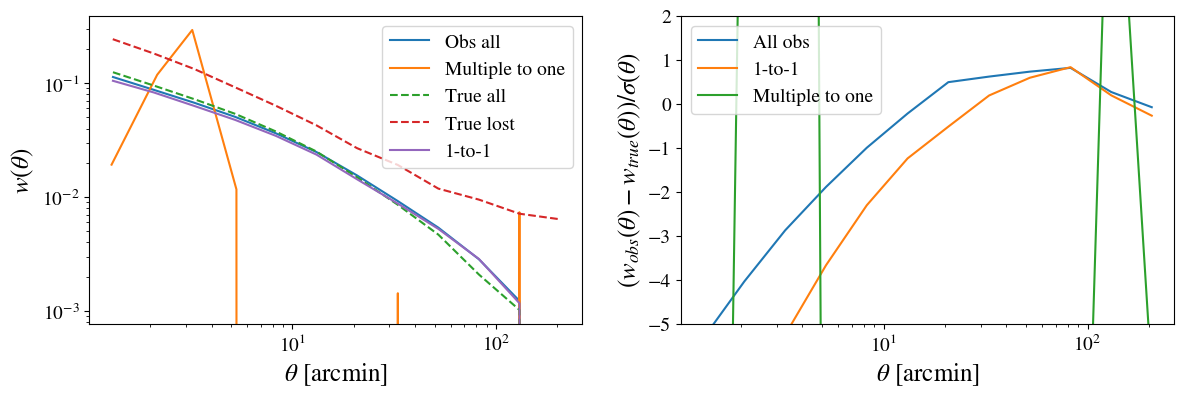

In [55]:
for ibin in range(5):
    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))
    ax[0].plot(theta_out['all'][ibin], w_out['all'][ibin], label='Obs all')
    ax[0].plot(theta_out['meas_other'][ibin], w_out['meas_other'][ibin], label='Multiple to one')
    ax[0].loglog(theta_out['true_all'][ibin], w_out['true_all'][ibin], label='True all', ls='--')
    ax[0].loglog(theta_out['true_lost'][ibin], w_out['true_lost'][ibin], label='True lost', ls='--')
    #ax[0].loglog(theta, w_out['artifact'][ibin], label='Artifacts')
    ax[0].loglog(theta_out['1t1'][ibin], w_out['1t1'][ibin], label='1-to-1')
    #ax[0].loglog(theta, w_out['mtm'][ibin], label='Many-to-many')
    ax[0].legend(loc='best')
    ax[0].set_xlabel(r'$\theta$ [arcmin]', fontsize=18)
    ax[0].set_ylabel(r'$w(\theta)$', fontsize=18)
    ax[1].plot(theta, (w_out['all'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='All obs')
    ax[1].plot(theta, (w_out['1t1'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='1-to-1')
    ax[1].plot(theta, (w_out['meas_other'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='Multiple to one')
    ax[1].legend(loc='best')
    ax[1].set_xscale('log')
    ax[1].set_ylim(-5, 2)
    ax[1].set_xlabel(r'$\theta$ [arcmin]', fontsize=18)
    ax[1].set_ylabel(r'$(w_{obs}(\theta)-w_{true}(\theta))/\sigma(\theta)$', fontsize=18)

In [60]:
w_out_all = dict()
for i in range(5):
    # theta_out_all['theta'] = theta
    w_out_all[f'theta_obs_all_{i}'] = theta_out['all'][i]
    w_out_all[f'theta_true_all_{i}'] = theta_out['true_all'][i]
    w_out_all[f'theta_true_lost_{i}'] = theta_out['true_lost'][i]
    w_out_all[f'theta_artifact_{i}'] = theta_out['artifact'][i]
    w_out_all[f'theta_obs_1to1_{i}'] = theta_out['1t1'][i]
    w_out_all[f'theta_obs_manytomany_{i}'] = theta_out['mtm'][i]
    w_out_all[f'theta_obs_other_{i}'] = theta_out['meas_other'][i]
    w_out_all[f'w_obs_all_{i}'] = w_out['all'][i]
    w_out_all[f'w_true_all_{i}'] = w_out['true_all'][i]
    w_out_all[f'w_true_lost_{i}'] = w_out['true_lost'][i]
    w_out_all[f'w_artifact_{i}'] = w_out['artifact'][i]
    w_out_all[f'w_obs_1to1_{i}'] = w_out['1t1'][i]
    w_out_all[f'w_obs_manytomany_{i}'] = w_out['mtm'][i]
    w_out_all[f'w_obs_other_{i}'] = w_out['meas_other'][i]
    w_out_all[f'w_err_obs_all_{i}'] = np.sqrt(np.diag(cov_out['all'][i]))
    w_out_all[f'w_err_true_all_{i}'] = np.sqrt(np.diag(cov_out['true_all'][i]))
    w_out_all[f'w_err_artifact_{i}'] = np.sqrt(np.diag(cov_out['artifact'][i]))
    w_out_all[f'w_err_true_lost_{i}'] = np.sqrt(np.diag(cov_out['true_lost'][i]))
    w_out_all[f'w_err_obs_1to1_{i}'] = np.sqrt(np.diag(cov_out['1t1'][i]))
    w_out_all[f'w_err_obs_manytomany_{i}'] = np.sqrt(np.diag(cov_out['mtm'][i]))
    w_out_all[f'w_err_obs_other_{i}'] = np.sqrt(np.diag(cov_out['meas_other'][i]))
    # w_out_all['rr'] = rr.npairs
    # w_out_all[f'rr_{i}'] = rr_out[i]

In [57]:
tab_out = astropy.table.Table(w_out_all)

In [58]:
tab_out.write('DC2_DR6_wtheta_07_05_2023_5bin.fits.gz', overwrite=True)

In [59]:
np.save('DC2_DR6_Nz_07_05_2023_5bin.npy', [nz_out, dndz_out])

# 10 bins

In [61]:
zedges = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

In [62]:
nz_out = {}
nz_out['all'] = {}
nz_out['1t1'] = {}
nz_out['mtm'] = {}
nz_out['meas_other'] = {}
nz_out['artifact'] = {}
nz_out['true_lost'] = {}
nz_out['true_all'] = {}
dndz_out = {}
dndz_out['all'] = {}
dndz_out['1t1'] = {}
dndz_out['mtm'] = {}
dndz_out['meas_other'] = {}
dndz_out['artifact'] = {}
dndz_out['true_lost'] = {}
dndz_out['true_all'] = {}

theta_out = {}
theta_out['all'] = {}
theta_out['1t1'] = {}
theta_out['mtm'] = {}
theta_out['meas_other'] = {}
theta_out['artifact'] = {}
theta_out['true_lost'] = {}
theta_out['true_all'] = {}
w_out = {}
w_out['all'] = {}
w_out['1t1'] = {}
w_out['mtm'] = {}
w_out['meas_other'] = {}
w_out['artifact'] = {}
w_out['true_lost'] = {}
w_out['true_all'] = {}
cov_out = {}
cov_out['all'] = {}
cov_out['1t1'] = {}
cov_out['mtm'] = {}
cov_out['meas_other'] = {}
cov_out['true_lost'] = {}
cov_out['true_all'] = {}
cov_out['artifact'] = {}

In [63]:
fraction_lost = []
num_old = 1
# rr_out = dict()
for i in range(len(zedges)-1):
    print(i)
    for key in masks.keys():
        print(key)
        if 'true' not in key:
            zmask = (tab_all['redshift_true'] > zedges[i]) & (tab_all['redshift_true'] < zedges[i+1])
            zmask = (zmask) & (masks[key])
            cat_here = tc.Catalog(ra=tab_all['ra'][zmask], dec=tab_all['dec'][zmask], 
                                 patch_centers=cat_rnd.patch_centers, ra_units='deg', dec_units='deg')
            nz, zbins = calculate_z_distribution(tab_all['redshift_true'][zmask], zedges[i], zedges[i+1])
        else:
            zmask = (data_truth['redshift_true'][good_truth] > zedges[i]) & (data_truth['redshift_true'][good_truth] < zedges[i+1])
            zmask = (zmask) & (masks[key])
            cat_here = tc.Catalog(ra=data_truth['ra'][good_truth][zmask], dec=data_truth['dec'][good_truth][zmask],
                                 patch_centers=cat_rnd.patch_centers, ra_units='deg', dec_units='deg')
            nz, zbins = calculate_z_distribution(data_truth['redshift_true'][good_truth][zmask], zedges[i], zedges[i+1])
        theta, w, cov = compute_corr(cat_here, cat_rnd)
        theta_out[key][i] = theta
        w_out[key][i] = w
        cov_out[key][i] = cov
        nz_out[key][i] = nz
        dndz_out[key][i] = zbins
        
        np.save(f'cov_DC2_DR6/cov_DC2_DR6_07_05_2023_10bin_{key}_{i}', cov)

0
all
1t1
mtm
meas_other
artifact
true_all
true_lost
1
all
1t1
mtm
meas_other
artifact
true_all
true_lost
2
all
1t1
mtm
meas_other
artifact
true_all
true_lost
3
all
1t1
mtm
meas_other
artifact
true_all
true_lost
4
all
1t1
mtm
meas_other
artifact
true_all
true_lost
5
all
1t1
mtm
meas_other
artifact
true_all
true_lost
6
all
1t1
mtm
meas_other
artifact
true_all
true_lost
7
all
1t1
mtm
meas_other
artifact
true_all
true_lost
8
all
1t1
mtm
meas_other
artifact
true_all
true_lost
9
all
1t1
mtm
meas_other
artifact
true_all
true_lost


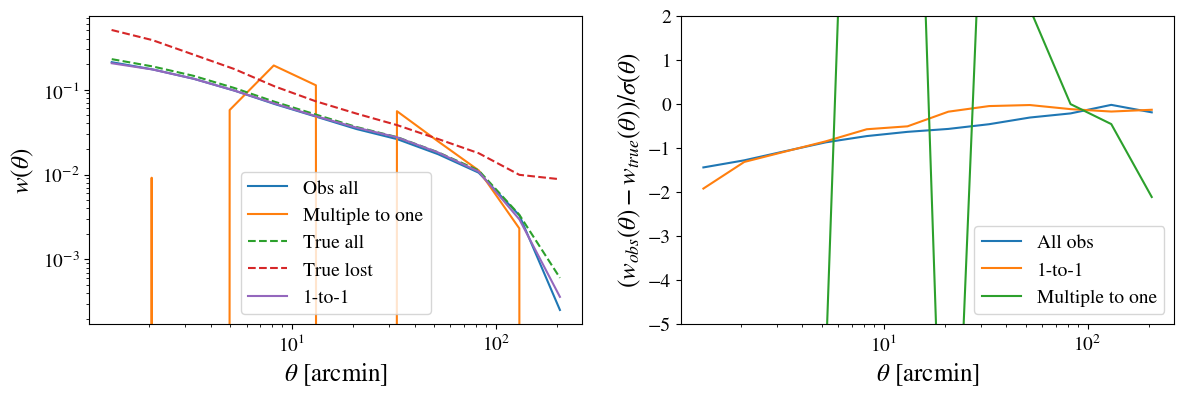

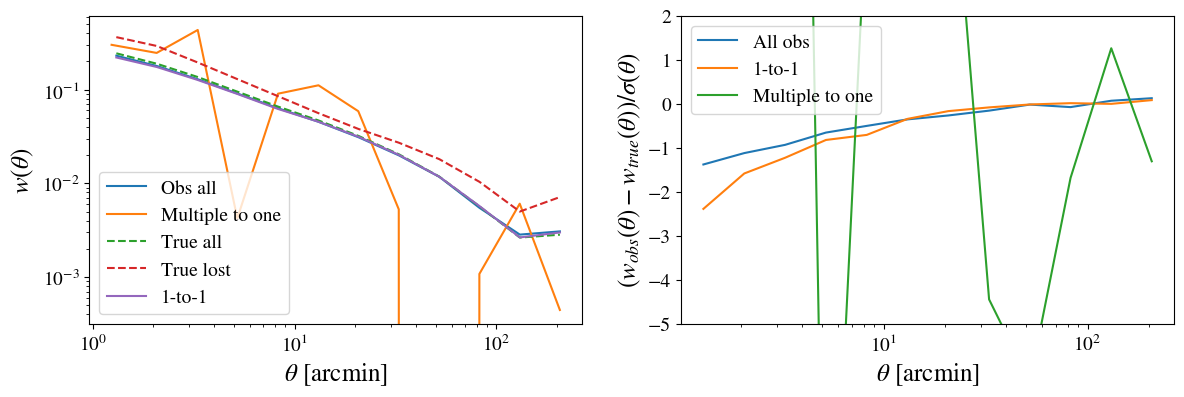

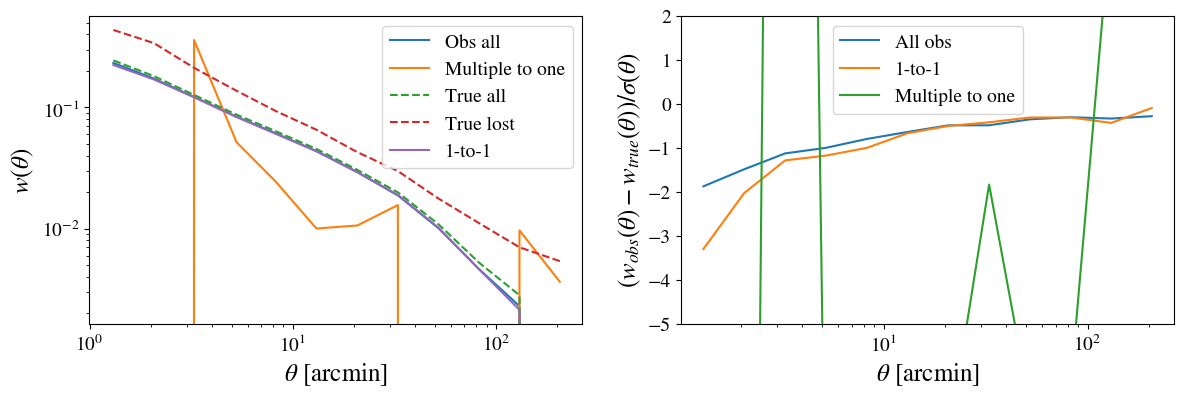

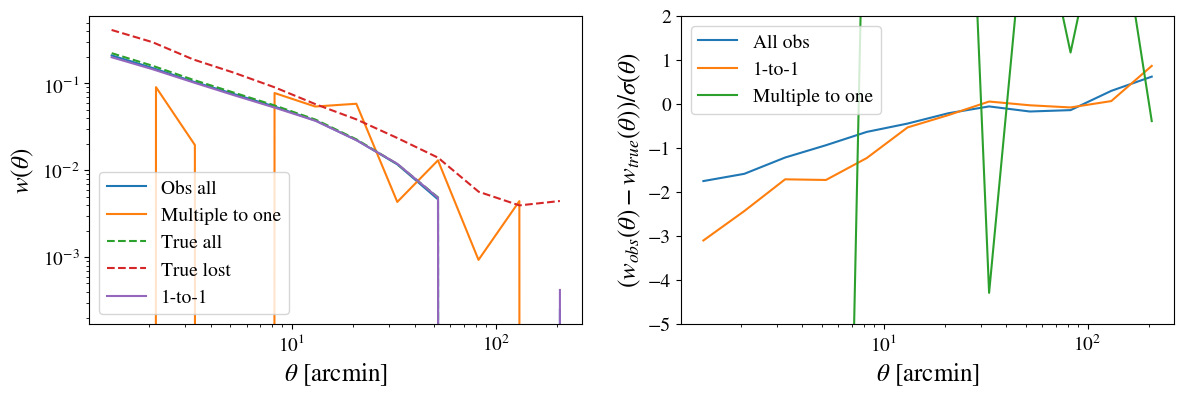

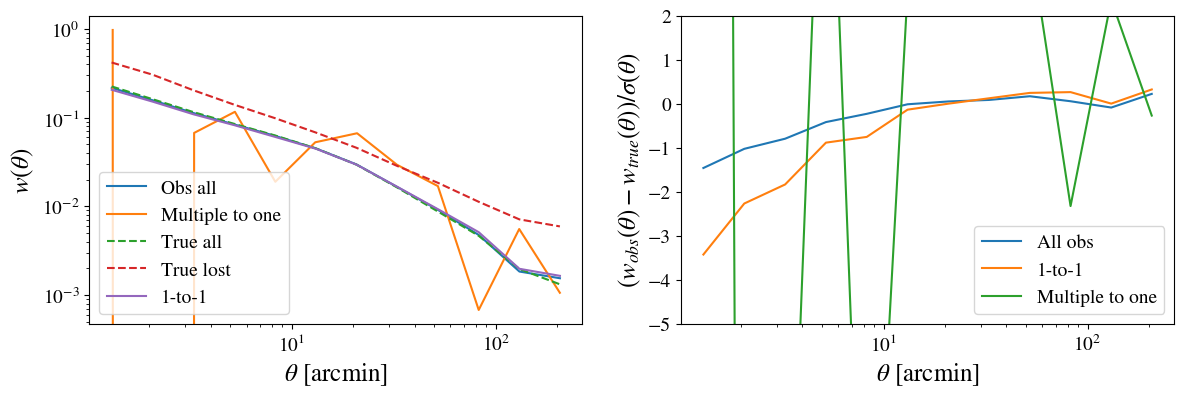

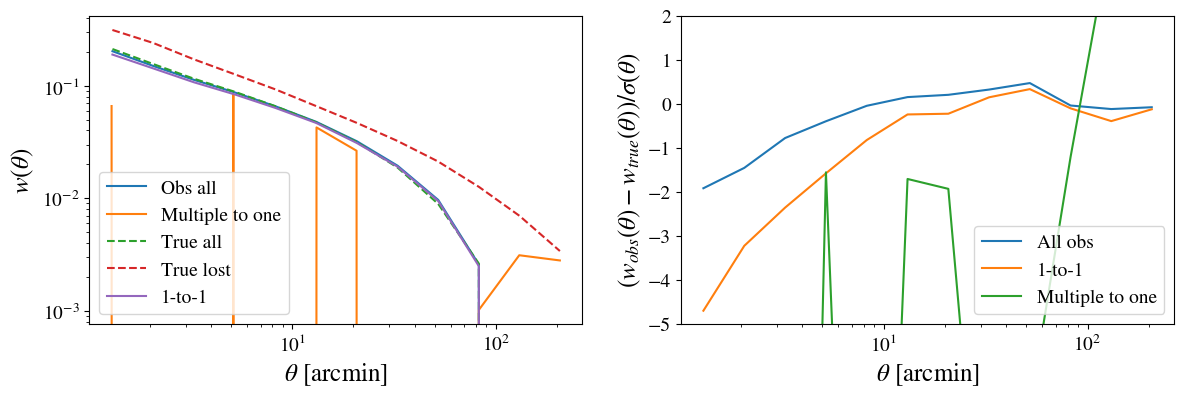

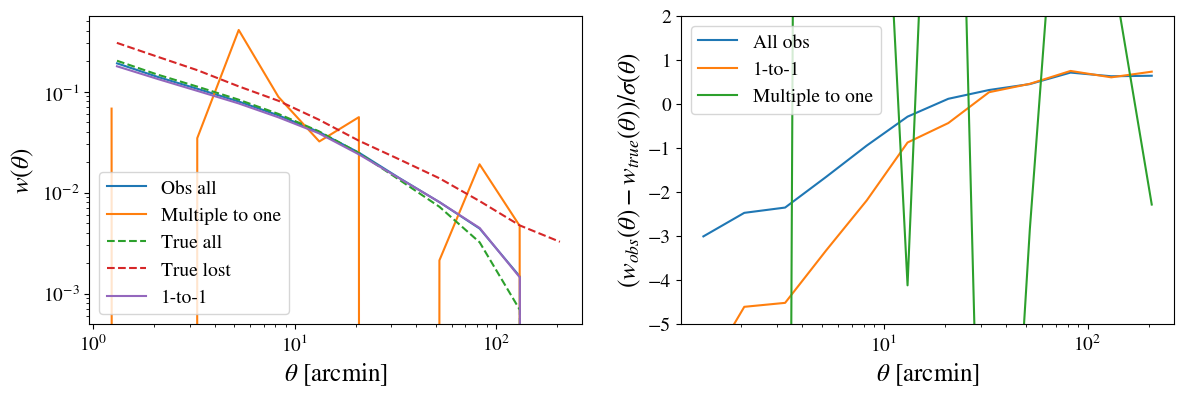

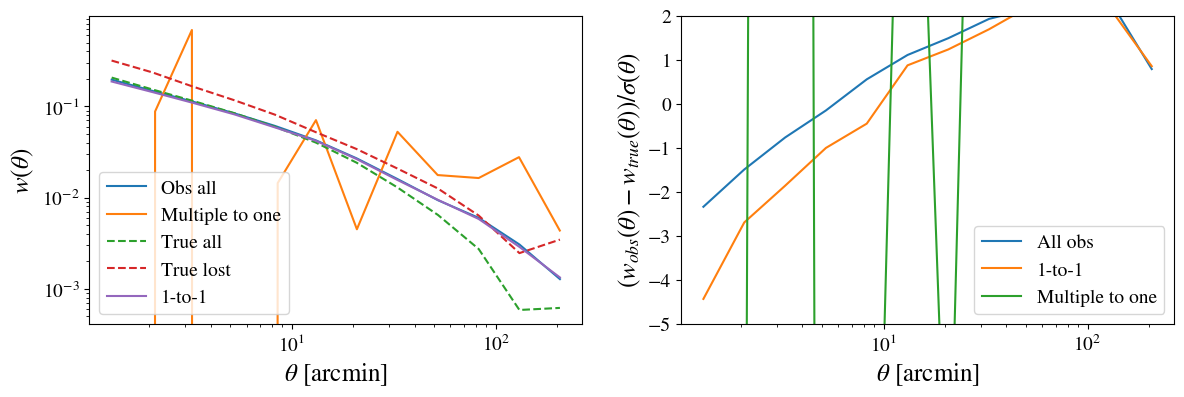

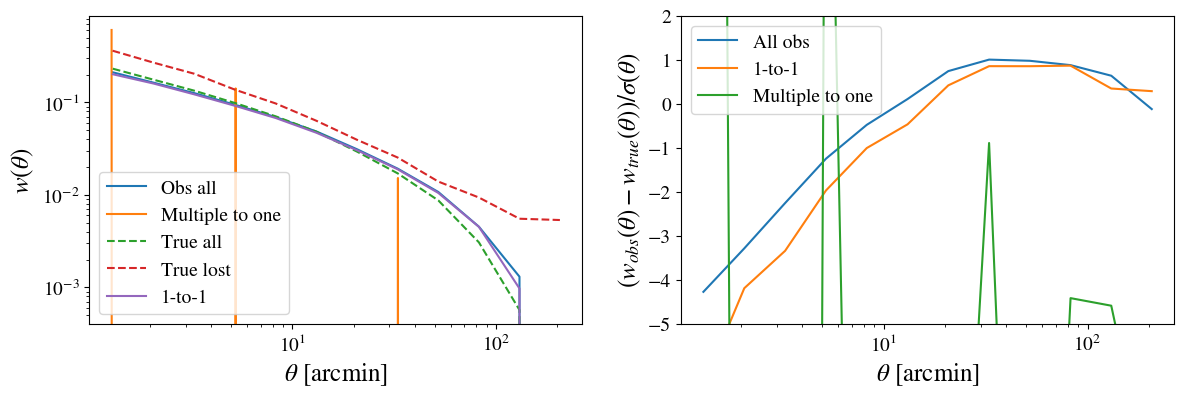

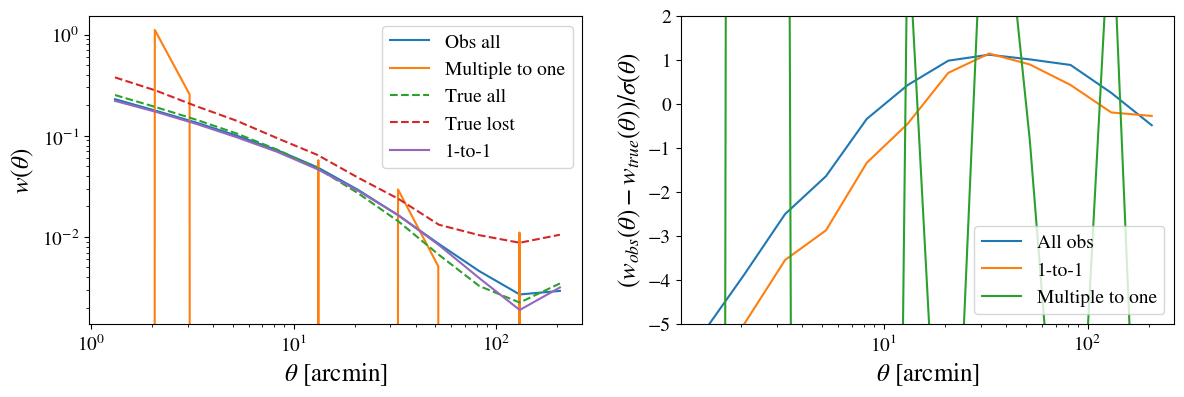

In [64]:
for ibin in range(10):
    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))
    ax[0].plot(theta_out['all'][ibin], w_out['all'][ibin], label='Obs all')
    ax[0].plot(theta_out['meas_other'][ibin], w_out['meas_other'][ibin], label='Multiple to one')
    ax[0].loglog(theta_out['true_all'][ibin], w_out['true_all'][ibin], label='True all', ls='--')
    ax[0].loglog(theta_out['true_lost'][ibin], w_out['true_lost'][ibin], label='True lost', ls='--')
    #ax[0].loglog(theta, w_out['artifact'][ibin], label='Artifacts')
    ax[0].loglog(theta_out['1t1'][ibin], w_out['1t1'][ibin], label='1-to-1')
    #ax[0].loglog(theta, w_out['mtm'][ibin], label='Many-to-many')
    ax[0].legend(loc='best')
    ax[0].set_xlabel(r'$\theta$ [arcmin]', fontsize=18)
    ax[0].set_ylabel(r'$w(\theta)$', fontsize=18)
    ax[1].plot(theta, (w_out['all'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='All obs')
    ax[1].plot(theta, (w_out['1t1'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='1-to-1')
    ax[1].plot(theta, (w_out['meas_other'][ibin]-w_out['true_all'][ibin])/np.sqrt(np.diag(cov_out['true_all'][ibin])), label='Multiple to one')
    ax[1].legend(loc='best')
    ax[1].set_xscale('log')
    ax[1].set_ylim(-5, 2)
    ax[1].set_xlabel(r'$\theta$ [arcmin]', fontsize=18)
    ax[1].set_ylabel(r'$(w_{obs}(\theta)-w_{true}(\theta))/\sigma(\theta)$', fontsize=18)

In [65]:
w_out_all = dict()
for i in range(5):
    # theta_out_all['theta'] = theta
    w_out_all[f'theta_obs_all_{i}'] = theta_out['all'][i]
    w_out_all[f'theta_true_all_{i}'] = theta_out['true_all'][i]
    w_out_all[f'theta_true_lost_{i}'] = theta_out['true_lost'][i]
    w_out_all[f'theta_artifact_{i}'] = theta_out['artifact'][i]
    w_out_all[f'theta_obs_1to1_{i}'] = theta_out['1t1'][i]
    w_out_all[f'theta_obs_manytomany_{i}'] = theta_out['mtm'][i]
    w_out_all[f'theta_obs_other_{i}'] = theta_out['meas_other'][i]
    w_out_all[f'w_obs_all_{i}'] = w_out['all'][i]
    w_out_all[f'w_true_all_{i}'] = w_out['true_all'][i]
    w_out_all[f'w_true_lost_{i}'] = w_out['true_lost'][i]
    w_out_all[f'w_artifact_{i}'] = w_out['artifact'][i]
    w_out_all[f'w_obs_1to1_{i}'] = w_out['1t1'][i]
    w_out_all[f'w_obs_manytomany_{i}'] = w_out['mtm'][i]
    w_out_all[f'w_obs_other_{i}'] = w_out['meas_other'][i]
    w_out_all[f'w_err_obs_all_{i}'] = np.sqrt(np.diag(cov_out['all'][i]))
    w_out_all[f'w_err_true_all_{i}'] = np.sqrt(np.diag(cov_out['true_all'][i]))
    w_out_all[f'w_err_artifact_{i}'] = np.sqrt(np.diag(cov_out['artifact'][i]))
    w_out_all[f'w_err_true_lost_{i}'] = np.sqrt(np.diag(cov_out['true_lost'][i]))
    w_out_all[f'w_err_obs_1to1_{i}'] = np.sqrt(np.diag(cov_out['1t1'][i]))
    w_out_all[f'w_err_obs_manytomany_{i}'] = np.sqrt(np.diag(cov_out['mtm'][i]))
    w_out_all[f'w_err_obs_other_{i}'] = np.sqrt(np.diag(cov_out['meas_other'][i]))

In [66]:
tab_out = astropy.table.Table(w_out_all)

In [67]:
tab_out.write('DC2_DR6_wtheta_07_05_2023_10bin.fits.gz', overwrite=True)

In [68]:
np.save('DC2_DR6_Nz_07_05_2023_10bin.npy', [nz_out, dndz_out])